# TEST PROJEKT1


## Dane i importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
! pip install category_encoders

     |████████████████████████████████| 86 kB 4.5 MB/s 


In [3]:
import category_encoders as ce

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
!wget https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/census_income_dataset.csv
df_raw = pd.read_csv('census_income_dataset.csv')

--2022-04-24 18:11:25--  https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/census_income_dataset.csv
Resolving lovespreadsheet-tutorials.s3.amazonaws.com (lovespreadsheet-tutorials.s3.amazonaws.com)... 52.216.107.148
Connecting to lovespreadsheet-tutorials.s3.amazonaws.com (lovespreadsheet-tutorials.s3.amazonaws.com)|52.216.107.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5717107 (5.5M) [text/csv]
Saving to: ‘census_income_dataset.csv’

census_income_datas 100%[===================>]   5.45M  8.02MB/s    in 0.7s    

2022-04-24 18:11:26 (8.02 MB/s) - ‘census_income_dataset.csv’ saved [5717107/5717107]



In [6]:
y = df_raw['income_level']
del df_raw['income_level']

In [7]:
X_build, X_val, y_build, y_val = train_test_split(df_raw, y, test_size=0.2, random_state=500, stratify=y)

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X_build, y_build, test_size=0.2, random_state=500, stratify=y_build)

Teraz mamy df do trainu i df_test do testowania

## Wybór zmiennych

Do oceny jakości zmiennych użyjemy Information Value

In [338]:
def genTab(col):
  racetab = pd.crosstab(X_train[col], y_train)
  racetab.columns=['bads','goods']
  racetab['%good']=racetab['goods']/racetab['goods'].sum()
  racetab['%bad']=racetab['bads']/racetab['bads'].sum()
  racetab['%bad']=racetab['%bad'].apply(lambda x: 0.00001 if x==0 else x)
  racetab['%good']=racetab['%good'].apply(lambda x: 0.00001 if x==0 else x)
  racetab['woe']=np.log(racetab['%good']/racetab['%bad'])
  racetab['iv']=(racetab['%good']-racetab['%bad'])*racetab['woe']
  return racetab

In [339]:
X_train['age'],bins = pd.qcut(X_train['age'], q = 10, labels=False, retbins=True)
X_train = X_train.astype({"age": str})
del X_train['education']
del X_train['fnlwgt']
X_train['capital_gain']=X_train['capital_gain'].apply(lambda x: "1" if x>0 else "2" )
X_train['capital_loss']=X_train['capital_loss'].apply(lambda x: "1" if x>0 else "2")
#X_train['hours_per_week']=X_train['hours_per_week'].apply(lambda x: "1" if x>40 else ("2" if x==40 else "3"))

In [340]:
ivs = []
for col in X_train.columns:
  print(col,genTab(col)['iv'].sum())
  ivs.append(genTab(col)['iv'].sum())

age 1.062335395478548
workclass 0.17744074082401887
education_num 0.7474264598100362
marital_status 1.3269871344481838
occupation 0.7783111520997515
relationship 1.5220698177589431
race 0.06328036474067357
sex 0.29721911989763894
capital_gain 0.3124767560683434
capital_loss 0.0826558864224394
hours_per_week 0.5094515106407002
native_country 0.09495237339859568


In [12]:
pd.DataFrame(zip(X_train.columns, ivs))

,0,1
0,age,1.263336
1,workclass,0.177441
2,education_num,0.747426
3,marital_status,1.326987
4,occupation,0.778311
5,relationship,1.522070
6,race,0.063280
7,sex,0.297219
8,capital_gain,0.312477
9,capital_loss,0.082656


[Text(0.5, 1.0, 'Information Value')]

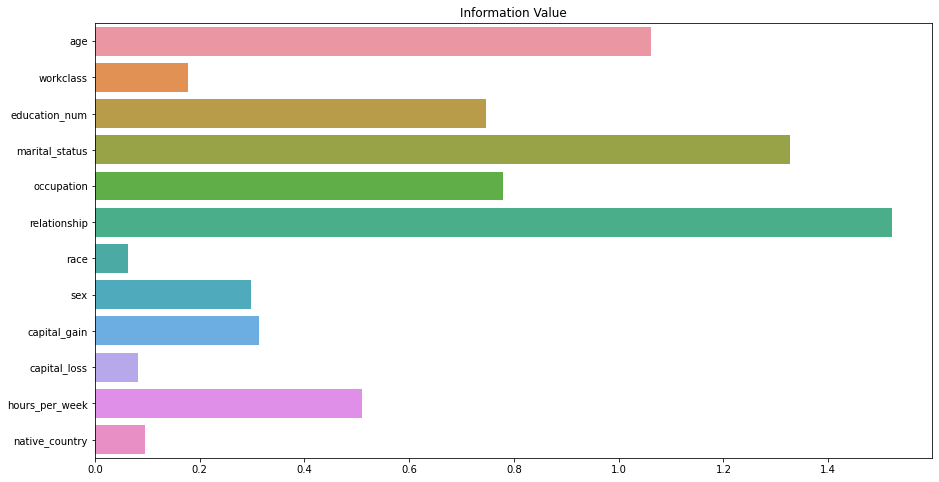

In [113]:
plt.figure(figsize = (15,8))
sns.barplot(y=X_train.columns, x=ivs).set(title="Information Value")

Monotoniczna zależność z targetem, podobnie to wygląda dla hours_per_week, capital_loss i capital_gain

In [341]:
genTab('education_num')

,bads,goods,%good,%bad,woe,iv
education_num,,,,,,
1,53,1,0.000134,0.002229,-2.813588,0.005895
2,145,5,0.000669,0.006098,-2.210592,0.012002
3,334,16,0.002139,0.014046,-1.881849,0.022407
4,577,39,0.005215,0.024265,-1.537577,0.029292
5,453,23,0.003075,0.019050,-1.823694,0.029134
6,837,56,0.007488,0.035199,-1.547769,0.042891
7,1123,57,0.007621,0.047227,-1.824004,0.072240
8,380,34,0.004546,0.015980,-1.257107,0.014374
9,8561,1608,0.215002,0.360024,-0.515522,0.074762


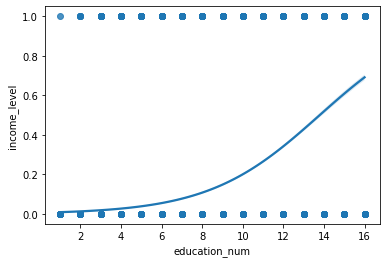

In [318]:
sns.regplot(x=X_train['education_num'], y=y_train, logistic=True)

## Preprocessing

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X_build, y_build, test_size=0.2, random_state=500, stratify=y_build)

WOE Encoding robimy tylko dla kolumn, które nie mają monotonicznego związku z zmienną target(wszytkie dyskretne i age)

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X_build, y_build, test_size=0.2, random_state=500, stratify=y_build)

In [322]:
cols_lepsze = ['age', 'workclass', 'marital_status', 'occupation',
       'relationship', 'native_country']

In [323]:
woeEncoder = ce.WOEEncoder(cols=cols_lepsze)

In [324]:
y_train = y_train.apply(lambda x: 1 if x=='>50K' else 0)

In [325]:
X_train['age'],bins = pd.qcut(X_train['age'], q = 10, labels=False, retbins=True)
#X_train['hours_per_week'],binsH = pd.qcut(X_train['hours_per_week'], q = 3, labels=False, retbins=True)#, #duplicates='drop')
X_train = X_train.astype({"age": str})
#X_train = X_train.astype({"hours_per_week": str})
#X_train = X_train.astype({"education_num": str})
del X_train['education']
del X_train['fnlwgt']
del X_train['race']
del X_train['sex']
#del X_train['capital_loss']
#X_train['capital_gain']=X_train['capital_gain'].apply(lambda x: "1" if x>0 else "2" )
#X_train['capital_loss']=X_train['capital_loss'].apply(lambda x: "1" if x>0 else "2")
#X_train['hours_per_week']=X_train['hours_per_week'].apply(lambda x: "3" if x>40 else ("2" if x==40 else "1"))

In [326]:
y_test = y_test.apply(lambda x: 1 if x=='>50K' else 0)

In [327]:
X_test['age'] = pd.cut(X_test['age'], bins=[0., 22., 26., 30., 33., 37., 41., 46., 51., 58., 100.], labels=False,)
#X_test['hours_per_week'] = pd.cut(X_test['hours_per_week'], bins=[ 0., 35., 40., 48., 120.], labels=False,)
#X_test = X_test.astype({"hours_per_week": str})
X_test = X_test.astype({"age": str})
#X_test = X_test.astype({"education_num": str})
del X_test['education']
del X_test['fnlwgt']
del X_test['race']
del X_test['sex']
#del X_test['capital_loss']
#X_test['capital_gain']=X_test['capital_gain'].apply(lambda x: "1" if x>0 else "2" )
#X_test['capital_loss']=X_test['capital_loss'].apply(lambda x: "1" if x>0 else "2")
#X_test['hours_per_week']=X_test['hours_per_week'].apply(lambda x: "1" if x>40 else ("2" if x==40 else "3"))

In [328]:
X_ez = woeEncoder.fit_transform(X_train, y_train)

In [71]:
X_train

,age,workclass,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country
33927,2,Private,10,Married-civ-spouse,Adm-clerical,Own-child,0.0,0.0,40.0,United-States
11872,4,Private,9,Separated,Adm-clerical,Unmarried,7443.0,0.0,35.0,United-States
34269,6,State-gov,11,Married-civ-spouse,Protective-serv,Husband,0.0,0.0,50.0,United-States
29168,5,Private,9,Married-civ-spouse,Craft-repair,Husband,0.0,0.0,40.0,United-States
7987,2,Private,10,Never-married,Machine-op-inspct,Not-in-family,0.0,0.0,40.0,United-States
...,...,...,...,...,...,...,...,...,...,...
45937,6,Private,9,Married-civ-spouse,Handlers-cleaners,Wife,0.0,0.0,48.0,United-States
25922,3,Private,10,Never-married,Craft-repair,Own-child,0.0,0.0,40.0,United-States
383,7,Private,10,Divorced,Sales,Not-in-family,0.0,0.0,40.0,United-States
2377,8,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,0.0,0.0,40.0,England


In [298]:
X_ez

,age,workclass,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country
33927,-0.586708,-0.122944,-0.275818,0.938695,-0.644110,-3.074009,0.0,0.0,40.0,0.020452
11872,0.302531,-0.122944,-0.515200,-1.399724,-0.644110,-1.584320,7443.0,0.0,35.0,0.020452
34269,0.591473,0.250169,0.080715,0.938695,0.359995,0.946833,0.0,0.0,50.0,0.020452
29168,0.483320,-0.122944,-0.515200,0.938695,-0.080783,0.946833,0.0,0.0,40.0,0.020452
7987,-0.586708,-0.122944,-0.275818,-1.852886,-0.841575,-1.003472,0.0,0.0,40.0,0.020452
...,...,...,...,...,...,...,...,...,...,...
45937,0.591473,-0.122944,-0.515200,0.938695,-1.493154,1.040001,0.0,0.0,48.0,0.020452
25922,-0.087864,-0.122944,-0.275818,-1.852886,-0.080783,-3.074009,0.0,0.0,40.0,0.020452
383,0.747833,-0.122944,-0.275818,-1.064952,0.147807,-1.003472,0.0,0.0,40.0,0.020452
2377,0.611153,-0.122944,-0.515200,0.938695,-0.841575,0.946833,0.0,0.0,40.0,0.732706


ZLaczenie bliskich WOE i znowu WOE

In [329]:
for col in cols_lepsze:
  X_ez[col] = round(X_ez[col],1)
  X_ez = X_ez.astype({col: str})

In [330]:
woeEncoder = ce.WOEEncoder(cols=cols_lepsze)
X_ez = woeEncoder.fit_transform(X_ez, y_train)

Zakodowanie przy pomocy dictionaries

In [25]:
import collections

In [331]:
for col in cols_lepsze:
  if col=='native_country':
    #na wypadek braku mało znanego kraju w ramce treningowej
    dik = dict(zip(X_train[col],X_ez[col]))
    defd = collections.defaultdict(lambda : dik['United-States'], dik)
    X_test[col] = X_test[col].map(defd)
  else:
    X_test[col] = X_test[col].map(dict(zip(X_train[col],X_ez[col])))


In [190]:
X_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country
33927,2,Private,10,Married-civ-spouse,Adm-clerical,Own-child,0.0,0.0,2,United-States
11872,4,Private,9,Separated,Adm-clerical,Unmarried,7443.0,0.0,1,United-States
34269,6,State-gov,11,Married-civ-spouse,Protective-serv,Husband,0.0,0.0,3,United-States
29168,5,Private,9,Married-civ-spouse,Craft-repair,Husband,0.0,0.0,2,United-States
7987,2,Private,10,Never-married,Machine-op-inspct,Not-in-family,0.0,0.0,2,United-States


In [286]:
X_ez.head()

,age,workclass,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country
33927,-0.586708,-0.122944,10,0.938695,-0.644110,-3.074009,0.0,0.0,40.0,0.020452
11872,0.302531,-0.122944,9,-1.399724,-0.644110,-1.584320,7443.0,0.0,35.0,0.020452
34269,0.591473,0.250169,11,0.938695,0.359995,0.946833,0.0,0.0,50.0,0.020452
29168,0.483320,-0.122944,9,0.938695,-0.080783,0.946833,0.0,0.0,40.0,0.020452
7987,-0.586708,-0.122944,10,-1.852886,-0.841575,-1.003472,0.0,0.0,40.0,0.020452


In [310]:
X_test.head()

,age,workclass,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country
36963,0.747833,-0.122944,1.348203,-1.852886,-0.841575,-1.003472,0.0,0.0,40.0,0.020452
39383,0.591473,-0.122944,1.348203,-1.852886,0.986621,-1.003472,0.0,0.0,40.0,-0.096242
18272,0.070128,-0.122944,2.139751,0.938695,0.986621,0.946833,0.0,0.0,30.0,0.020452
26474,-0.586708,-0.122944,-0.515200,-1.399724,-1.930533,-1.584320,0.0,0.0,30.0,0.020452
19066,0.611153,0.248034,-0.515200,0.938695,-0.644110,0.946833,0.0,0.0,40.0,0.020452


In [252]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7815 entries, 36963 to 32204
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             7815 non-null   float64
 1   workclass       7815 non-null   float64
 2   education_num   7815 non-null   float64
 3   marital_status  7815 non-null   float64
 4   occupation      7815 non-null   float64
 5   relationship    7815 non-null   float64
 6   capital_gain    7815 non-null   float64
 7   capital_loss    7815 non-null   float64
 8   hours_per_week  7815 non-null   int64  
 9   native_country  7815 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 671.6 KB


## Modelowanie

Zaimportujmy niezbędne biblioteki.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### LogisticRegression

In [ ]:
lr_base = LogisticRegression(random_state=42)
lr_base.fit(X_ez, y_train)
lr_base.score(X_ez,y_train)

0.8351781943822382

In [ ]:
print(lr_base.score(X_ez,y_train), f1_score(lr_base.predict(X_test),y_test))

0.8351781943822382 0.6298890834792762


Dobierzmy hiperparametry za pomocą GridSearcha.

In [ ]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'tol': [1e-4, 1e-3, 1e-5, 3e-4]
}

lr_model = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = lr_model, param_grid = param_grid_lr, error_score=0.0,
                    cv = 5)

grid_result = grid.fit(X_ez, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.851846 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}


In [ ]:
ct = ColumnTransformer([
        ('scaler', StandardScaler(), ['education_num', 'hours_per_week','capital_loss','capital_gain'])
    ], remainder='passthrough')

In [274]:
pipe = Pipeline([('scaler', ColumnTransformer([
        ('scaler', StandardScaler(), ['education_num', 'hours_per_week','capital_loss','capital_gain'])
    ], remainder='passthrough')), ('logisticRegression', LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 10, tol = 0.0001, random_state=42))])

In [275]:
pipe.fit(X_ez, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['education_num',
                                                   'hours_per_week',
                                                   'capital_loss',
                                                   'capital_gain'])])),
                ('logisticRegression',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

Scaler nie zmienil predykcyjności, nie dodaje też do interpretowalności

In [276]:
print(accuracy_score(pipe.predict(X_test),y_test), f1_score(pipe.predict(X_test),y_test), roc_auc_score(pipe.predict(X_test),y_test), auc)

0.854766474728087 0.6652904747861986 0.8118636514911355 <function auc at 0x7f6a379f9170>


**Best regresja**

In [332]:
lr_best = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 10, tol = 0.0001, random_state=42)
lr_best.fit(X_ez, y_train)

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

jej scory

In [333]:
print(lr_best.score(X_test,y_test), f1_score(lr_best.predict(X_test),y_test), roc_auc_score(lr_best.predict(X_test),y_test), precision_score(lr_best.predict(X_test),y_test), recall_score(lr_best.predict(X_test),y_test))

0.85489443378119 0.6648936170212765 0.8124147642162018 0.6016042780748663 0.7430647291941875


In [334]:
print(lr_best.score(X_ez,y_train), f1_score(lr_best.predict(X_ez),y_train))

0.8514300339113187 0.6556939501779359


Zwizualizujmy sobie nasz ROC AUC.

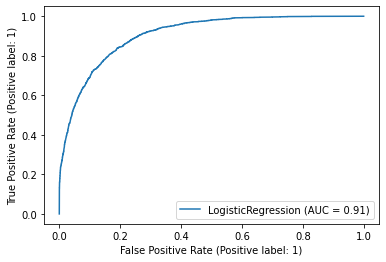

In [335]:
plot_roc_curve(lr_best, X_test, y_test)

In [ ]:
! pip install scikit-optimize

     |████████████████████████████████| 100 kB 7.6 MB/s 


Użyjmy wyszukiwania Bayesowskiego w celu sprawdzenia czy mogą istnieć jakieś lepsze hiperparametry.

In [ ]:
from skopt import BayesSearchCV

opt = BayesSearchCV(
    LogisticRegression(),
    {
        'C': (0.0001, 10000),
        'penalty': ['l1', 'l2', 'none'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'tol': (1e-5, 10)
    },
    error_score = 0.0,
    n_iter=50,
    cv=5
)

opt.fit(X_ez, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("Best params: %s" % opt.best_params_)

val. score: 0.851622112822793
test score: 0.8551503518873961
Best params: OrderedDict([('C', 2645.3596662342547), ('penalty', 'l2'), ('solver', 'newton-cg'), ('tol', 5.812896926792161)])


In [ ]:
X_test['native_country'].unique()

array(['United-States', 'Hungary', 'Vietnam', '?', 'Greece', 'Taiwan',
       'Poland', 'Mexico', 'Germany', 'El-Salvador', 'Iran', 'Japan',
       'England', 'Canada', 'Puerto-Rico', 'Ireland',
       'Dominican-Republic', 'Nicaragua', 'Peru', 'Cuba', 'Portugal',
       'Guatemala', 'South', 'India', 'China', 'Philippines',
       'Outlying-US(Guam-USVI-etc)', 'France', 'Italy', 'Jamaica',
       'Yugoslavia', 'Scotland', 'Trinadad&Tobago', 'Haiti', 'Ecuador',
       'Thailand', 'Honduras', 'Hong', 'Columbia', 'Laos', 'Cambodia'],
      dtype=object)

In [ ]:
X_test['native_country']

36963    0.020452
39383   -0.096242
18272    0.020452
26474    0.020452
19066    0.020452
           ...   
38279    0.020452
33909    0.020452
8414     0.265098
22133    0.020452
32204    0.499741
Name: native_country, Length: 7815, dtype: float64

In [ ]:
f1_score(lr_best.predict(X_test),y_test)

0.6454869358669835

z laczeniem 0.843891024569614 0.640234287001577 0.8007503940163941

bez laczenia woe 0.843891024569614 0.6400900900900901 0.8005549116235828

0.8435985291659702 0.6397837350754675 0.8004331706134287

0.843891024569614 0.6405405405405405 0.8008720101629819

In [ ]:
lr_test_xd = LogisticRegression(penalty = 'l2', solver = 'saga', C = 1, tol = 0.001, random_state=1, max_iter=1000)
lr_test_xd.fit(X_ez, y_train)
lr_test_xd.score(X_ez,y_train)

0.842136052147752

In [ ]:
from sklearn.preprocessing import StandardScaler
X_ez_scaler_applied = X_ez.copy()
scaler = StandardScaler()
X_ez_scaler_applied = scaler.fit_transform(X_ez_scaler_applied)

In [ ]:
lr_base2 = LogisticRegression(random_state=42)
lr_base2.fit(X_ez_scaler_applied, y_train)
lr_base2.score(X_ez_scaler_applied,y_train)

0.8420942670900886

In [ ]:
lr_model2 = LogisticRegression(random_state=42)
grid2 = GridSearchCV(estimator = lr_model, param_grid = param_grid_lr, error_score=0.0,
                    cv = 4, n_jobs = -1, verbose = 2)

grid_result2 = grid.fit(X_ez_scaler_applied, y_train)
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))

Fitting 4 folds for each of 280 candidates, totalling 1120 fits
Best: 0.842303 using {'C': 0.1, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}


### KNeighbours

In [ ]:
n_neighbors = [5, 7, 9, 11, 13, 15]
weights = ['uniform', 'distance']
metric = ['minkowski', 'euclidean', 'manhattan']
param_grid = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

knn_model = KNeighborsClassifier()
grid = GridSearchCV(estimator = knn_model, param_grid = param_grid,
                    cv = 3, n_jobs = -1, verbose = 2)

grid_result = grid.fit(X_ez, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best: 0.837498 using {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


In [ ]:
kn_best = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 15, weights = 'uniform')

### Random forest

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()
grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_result = grid.fit(X_ez, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best: 0.844392 using {'criterion': 'gini', 'max_depth': 80, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 1000}


In [ ]:
rf_best = RandomForestClassifier(criterion = 'gini', max_depth = 80, min_samples_leaf = 5, min_samples_split = 8, n_estimators = 1000)

### XGBoost

In [ ]:
! pip install xgboost
import xgboost
from xgboost import XGBClassifier

In [ ]:
model=XGBClassifier()
model.fit(X_ez, y_train)
model.score(X_test,y_test)

0.8479087452471483

In [ ]:
param_grid_xgboost = {
    'max_depth': [8, 10, 12, 14, 16, 18, None],
    'learning_rate': [0.03, 0.1, 0.3, 0.001],
    'splitter': ["best", "random"],
    'max_features': ["auto", None]
}

xgboost = XGBClassifier(random_state = 42)
xgboost_grid = GridSearchCV(xgboost, param_grid_xgboost, cv = 2)
result = xgboost_grid.fit(X_ez, y_train)

Best: 0.844392 using {'criterion': 'gini', 'max_depth': 80, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 1000}


In [ ]:
xgb_best = XGBClassifier(learning_rate = 0.03, max_depth = 8, max_features = 'auto', splitter = 'best')

### Podsumowanie

In [ ]:
test_results = []
for model, model_name in [(lr_best, "LogisticRegression"), (rf_best, "RandomForest"), (kn_best, "KNeighbors"), (xgb_best, "XGBoost")]:
    model.fit(X_ez, y_train)
    y_pred = model.predict(X_test)
    measures_results = {"model": model_name}
    for measure in [accuracy_score, f1_score, roc_auc_score]:
        measures_results[measure.__name__] = measure(y_test, y_pred)
    test_results.append(measures_results)
    
test_results_df = pd.DataFrame(test_results)

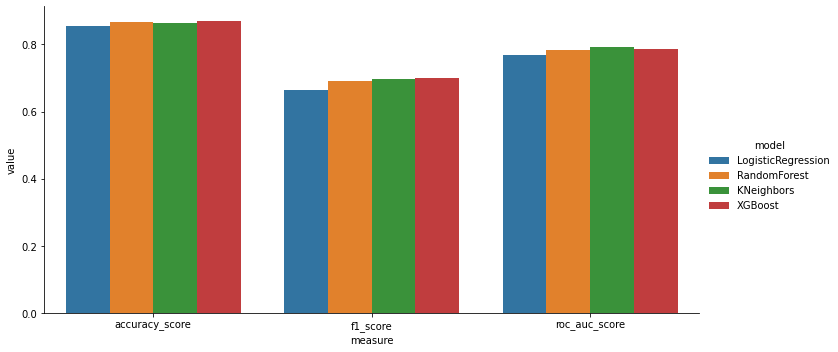

In [ ]:
test_results_df = pd.melt(test_results_df, id_vars="model", var_name="measure", value_name="value")
sns.catplot(x='measure', y='value', hue='model', data=test_results_df, kind='bar', aspect=2)
plt.show()

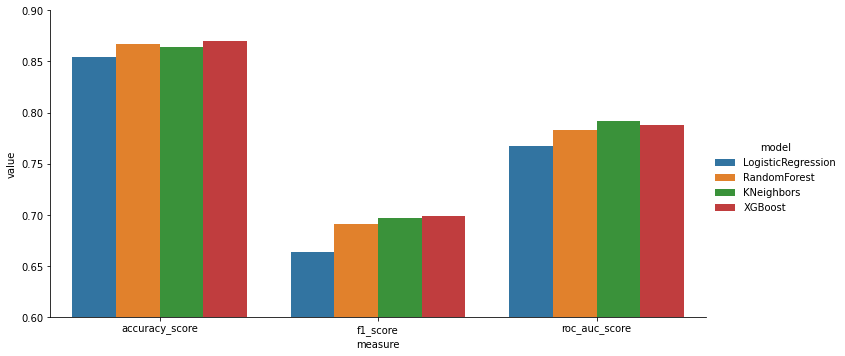

In [ ]:
sns.catplot(x='measure', y='value', hue='model', data=test_results_df, kind='bar', aspect=2)
plt.ylim(0.60, 0.9)
plt.show()

Finalnie użyta zostanie regresja logistyczna z uwagi na jej interpretowalność i prostotę. Nie daje ona wcale zdecydowanie gorszych wyników od bardziej zaawansowanych modeli. Cały preprocessing został również wykonany "pod nią".